In [53]:
%load_ext autoreload
%autoreload 2
from common import *
from envs import *
from copy import deepcopy
from RiskAverseMCTS import RiskAverseMCTS
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
N_alpha = 2
N_params = 2
N_rollouts = 50
N_iter = 100
alpha_vals = np.linspace(0.5,1.0,N_alpha)
param_vals = np.arange(N_params)
mdps = [NPullBandit(param=p) for p in param_vals]
rewards = np.zeros([N_alpha, N_params, N_rollouts])
belief = np.ones(N_params, dtype='float')/N_params

In [75]:
import cProfile
agent = RiskAverseMCTS(mdps, belief, max_depth=6, 
                               alpha=1.0, max_r=3., n_iter=100 )
env = Env(mdps[0], agent)
#cProfile.run("env.rollout(n_rollouts=1, render=False)")
stats = env.rollout(n_rollouts=10, render=False)
print(np.array(stats.trajectories)[:,:,1])

[[ 0.  0.  3.  0.  3.  0.]
 [ 0.  0.  3.  0.  1.  0.]
 [ 0.  0.  3.  0.  1.  0.]
 [ 0.  0.  3.  0.  1.  0.]
 [ 0.  0.  3.  0.  0.  0.]
 [ 0.  0.  3.  0.  3.  0.]
 [ 0.  0.  3.  0.  1.  0.]
 [ 0.  0.  3.  0.  1.  0.]
 [ 0.  0.  3.  0.  3.  0.]
 [ 0.  0.  1.  0.  1.  0.]]


In [35]:
agent.Qha

{(0, 0): 0.6991228070175437,
 (0, 0, 3, 0): 0.9547169811320757,
 (0, 0, 3, 0, 0, 0): 0.47500000000000003,
 (0, 0, 3, 0, 0, 0, 3, 0): 0.375,
 (0, 0, 3, 0, 0, 0, 3, 0, 0, 0): 0.1,
 (0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3, 0): 0.0,
 (0, 0, 3, 0, 0, 0, 3, 0, 0, 1): 0.6,
 (0, 0, 3, 0, 0, 0, 3, 0, 0, 1, 2, 0): 0.0,
 (0, 0, 3, 0, 0, 0, 3, 0, 0, 2): 0.0,
 (0, 0, 3, 0, 0, 0, 3, 0, 0, 3): 0.5,
 (0, 0, 3, 0, 0, 0, 3, 0, 0, 3, 1, 0): 0.0,
 (0, 0, 3, 0, 0, 0, 3, 0, 0, 3, 4, 0): 0.0,
 (0, 0, 3, 0, 0, 1): 1.08,
 (0, 0, 3, 0, 0, 1, 2, 0): 0.48,
 (0, 0, 3, 0, 0, 1, 2, 0, 0, 0): 0.1,
 (0, 0, 3, 0, 0, 1, 2, 0, 0, 0, 3, 0): 0.0,
 (0, 0, 3, 0, 0, 1, 2, 0, 0, 1): 0.6,
 (0, 0, 3, 0, 0, 1, 2, 0, 0, 1, 2, 0): 0.0,
 (0, 0, 3, 0, 0, 1, 2, 0, 0, 2): 0.5,
 (0, 0, 3, 0, 0, 1, 2, 0, 0, 2, 1, 0): 0.0,
 (0, 0, 3, 0, 0, 1, 2, 0, 0, 2, 4, 0): 0.0,
 (0, 0, 3, 0, 0, 1, 2, 0, 0, 3): 0.75,
 (0, 0, 3, 0, 0, 1, 2, 0, 0, 3, 1, 0): 0.0,
 (0, 0, 3, 0, 0, 1, 2, 0, 0, 3, 4, 0): 0.0,
 (0, 0, 3, 0, 0, 2): 0.7909090909090909,
 (0, 0, 3, 0, 

We perform a rollout on every MDP with every $\alpha$ value

In [79]:
for i, alpha in enumerate(alpha_vals):
    for j, mdp in enumerate(mdps):
        agent = RiskAverseMCTS(mdps, belief, max_depth=6, 
                               alpha=alpha, max_r=1., n_iter=N_iter )
        env = Env(mdp, agent)
        stats = env.rollout(n_rollouts=N_rollouts, render=False)
        rewards[i,j,:] = stats.total_rewards
        print("\r a =",alpha,"\tmdp",j,"reward:", np.mean(stats.total_rewards), end='', flush='True')
    print("\r a =",alpha,"\tavg_r:",np.mean(rewards[i,:,:]), "\tvar_r:", np.var(np.mean(rewards[i,:,:], axis=1)), flush='True')

 a = 0.5 	avg_r: 1.065 	var_r: 0.060025
 a = 1.0 	avg_r: 1.455 	var_r: 0.180625


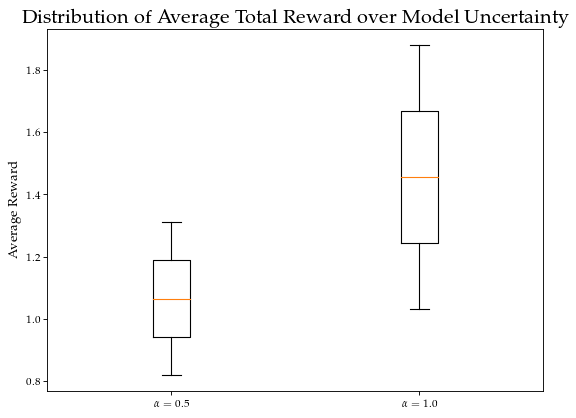

In [80]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
labels = [r"$\alpha="+str(a)+r"$" for a in alpha_vals]
plt.boxplot(np.mean(rewards[:,:,:], axis=2).T, labels=labels)
plt.title("Distribution of Average Total Reward over Model Uncertainty", fontsize=18)
plt.ylabel("Average Reward", fontsize=12)
#plt.xlabel("Avg Total Cost under Model", fontsize=16)
plt.legend(fontsize=16)
#plt.savefig('performance_gridworld_spreads_5.pdf')
plt.show()

# Convergence plots

In [82]:
belief_curves = []
agent_value_curves = []
adv_value_curves = []
final_q_vals = []
final_n_vals = []
for i, alpha in enumerate(alpha_vals):
    agent = RiskAverseMCTS(mdps, belief, max_depth=6, 
                               alpha=alpha, max_r=10., n_iter=200 )
    s0 = mdps[0].reset()
    agent.MCTS(s0)
    belief_curves.append(deepcopy(agent.adv_dists))
    agent_value_curves.append(deepcopy(agent.agent_est_value))
    adv_value_curves.append(deepcopy(agent.adv_est_value))
    final_q_vals.append( [agent.Qha[(s0,a)] for a in mdps[0].action_space(s0)] )
    final_n_vals.append( [agent.Wha[(s0,a)] for a in mdps[0].action_space(s0)] )

In [83]:
(1 - np.array(final_q_vals)).T

array([[ 0.15492805,  0.67214419],
       [ 1.01252964,  0.05315056],
       [ 0.56314186,  0.94113278],
       [ 1.21478262,  0.99121901]])

In [56]:
np.array(final_n_vals).T

array([[  782.36024212,   961.        ],
       [  491.25407097,  1044.        ],
       [ 7245.07549329,  4227.        ],
       [ 1481.31019362,  3768.        ]])

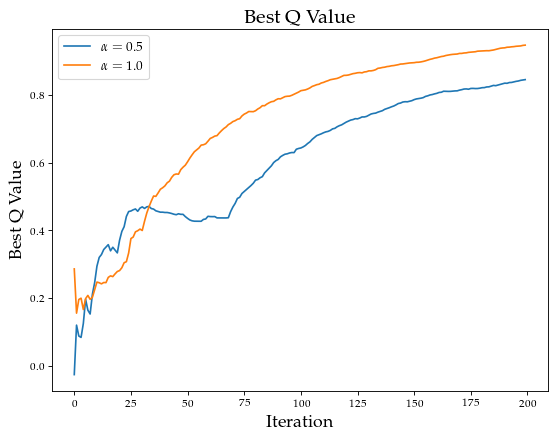

In [84]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
true_vals = [0.8,0.767,0.711,0.625,0.556,0.500]
for i,a in enumerate(alpha_vals):
    plt.plot(np.array(agent_value_curves)[i], label=(r"$\alpha="+str(a)+r"$"))
#     plt.holdon
#     plt.plot([0,n_iter],[true_vals[i], true_vals[i]], linestyle='--')
plt.title("Best Q Value", fontsize=18)
plt.ylabel("Best Q Value", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.show()

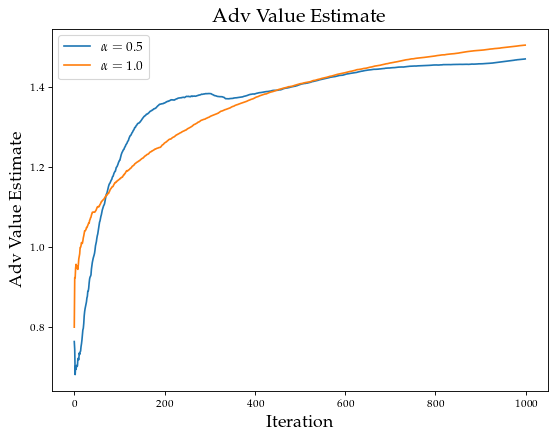

In [70]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i,a in enumerate(alpha_vals):
    plt.plot(np.array(adv_value_curves)[i], label=(r"$\alpha="+str(a)+r"$"))
plt.title("Adv Value Estimate", fontsize=18)
plt.ylabel("Adv Value Estimate", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [217]:
belief_curves = np.array(belief_curves)

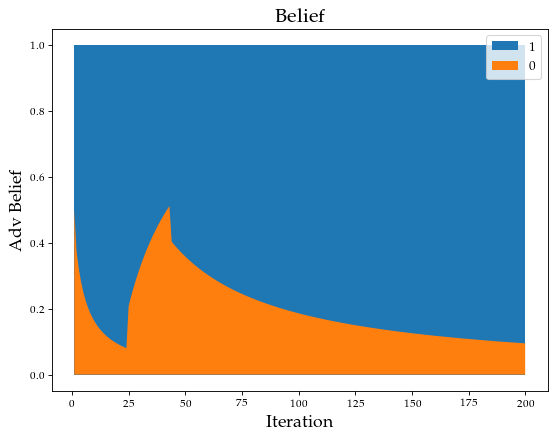

In [85]:
cum_belief_curves = np.cumsum(belief_curves, axis=2)
iterations = np.concatenate([[1],np.arange(cum_belief_curves.shape[1])+1,[cum_belief_curves.shape[1]]])
cum_belief_curves = np.concatenate([np.zeros([cum_belief_curves.shape[0],1,cum_belief_curves.shape[2]]),cum_belief_curves,np.zeros([cum_belief_curves.shape[0],1,cum_belief_curves.shape[2]])], axis=1)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i in reversed(range(N_params)):
    plt.fill(iterations,cum_belief_curves[0,:,i], label=str(i))
plt.title("Belief", fontsize=18)
plt.ylabel("Adv Belief", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.show()